# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

In [3]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("sparkify").getOrCreate()

In [4]:
# Read dataset
df = spark.read.json('mini_sparkify_event_data.json')

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [6]:
print(df.columns)

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We will first start with exploring different coloumns. Below we see what are distinct values associated with levels, method and page column

In [8]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [9]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [10]:
df.select("page").distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [11]:
# Remove column with null value or empty userid or null gender
df = df.filter(df["userId"] != "")
# Now compute total distinct users in the dataframe
df.select("userId").distinct().count()

225

In [12]:
# Lets count total number of unique session Ids
df.select('sessionId').dropDuplicates().count()

2312

In [13]:
# Create a churn column as suggested, I am also looking at submit downgrade or downgrade events separately
df = df.withColumn("churn", F.when(df.page == "Cancellation Confirmation", 1).otherwise(0))
df = df.withColumn("downgrade", F.when((df.page == "Submit Downgrade") | (df.page == 'Downgrade'), 1).otherwise(0))
df = df.withColumn("cancelled", F.when((df.page == 'Cancel'), 1).otherwise(0))

In [14]:
df.dropDuplicates(["userId", "churn"]).groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  225|
+-----+-----+



In [15]:
df.dropDuplicates(["userId", "downgrade"]).groupBy('downgrade').count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|        1|  154|
|        0|  225|
+---------+-----+



### Discussion 1: From above two tables, we can observe that there are only 52 churn events. So most of users can be assumed to not churn. For downgrade events there are more events, so a larger proportion of users visit downgrade page or submit downgrade option

In [16]:
# we now analyse if churn depends on user level. 
churn_level = df.dropDuplicates(["userId", "churn"]).groupBy('churn', 'level').count()
churn_level_df = churn_level.toPandas()

In [17]:
churn_level_per = df.dropDuplicates(['level', 'churn', 'userId']) \
    .groupby('churn', 'level') \
    .agg(F.count('userId').alias('userid_count')) \
    .withColumn("percentage", F.col("userid_count") / F.sum("userid_count").over(Window.partitionBy("churn")))

In [18]:
churn_level_df = churn_level_per.toPandas()

In [19]:
churn_level_df

,churn,level,userid_count,percentage
0,1,paid,31,0.596154
1,1,free,21,0.403846
2,0,free,195,0.541667
3,0,paid,165,0.458333


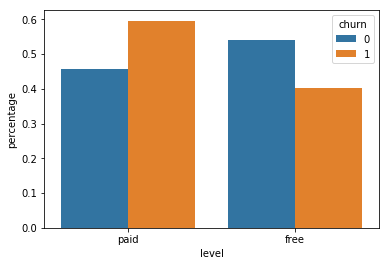

In [20]:
sns.barplot(x = "level",       # x variable name
            y = "percentage",       # y variable name
            hue = "churn",  # group variable name
            data = churn_level_df)

In [21]:
# Describe statistics of churn events when grouped by userID. 
df.select(['userId', 'churn']).groupBy('userId').sum('churn').describe().show()

+-------+------------------+------------------+
|summary|            userId|        sum(churn)|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



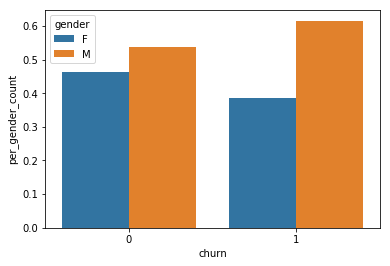

In [22]:
# Lets see effect of gender in churn
churn_per = df.select(['gender', 'churn', 'userId']) \
    .distinct().groupby('churn', 'gender') \
    .agg(F.count('gender').alias('gender_count')) \
    .withColumn("per_gender_count", F.col("gender_count") / F.sum("gender_count").over(Window.partitionBy("churn")))
churn_df = churn_per.toPandas()
sns.barplot(x = "churn",       # x variable name
            y = "per_gender_count",       # y variable name
            hue = "gender",  # group variable name
            data = churn_df)

In [23]:
churn_df

,churn,gender,gender_count,per_gender_count
0,1,F,20,0.384615
1,1,M,32,0.615385
2,0,M,121,0.537778
3,0,F,104,0.462222


### Discussion  2: In both the cases churn vs non-churn - Male has higher percentage than females. Further there are more male users than female.


In [24]:
# Lets try to analyse customers (churned or not churned) based on different page visits
df.withColumn('next_song', F.when(df.page == "NextSong", 0)\
              .otherwise(1)).groupBy('churn').agg(F.mean('next_song').alias('mean_next_song')).show()

+-----+------------------+
|churn|    mean_next_song|
+-----+------------------+
|    1|               1.0|
|    0|0.1797685741202868|
+-----+------------------+



In [25]:
df.filter(df.userId==100010).select('registration').distinct().show()

+-------------+
| registration|
+-------------+
|1538016340000|
+-------------+



In [26]:
# so each user seems to have one registration id.. some may have multiples. Let count it for each user
df.select(['userId', 'registration']).groupBy('userId').agg(F.countDistinct('registration').alias('reg_count')).\
    orderBy(F.desc('reg_count')).show(5)

+------+---------+
|userId|reg_count|
+------+---------+
|100010|        1|
|200002|        1|
|   125|        1|
|    51|        1|
|   124|        1|
+------+---------+
only showing top 5 rows



### Discussion 3: From above table it is clear that each user has only one registration ID. So registration id is a unqiue attribute and is not of much importance when doing any kind of modelling

In [27]:
# Create a window partition over userID and order by time stamp
windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [28]:
df = df.withColumn("churn_phase", F.sum("churn").over(windowval))
# Any user who churns will have churn_phase == 1

In [29]:
df.select(["userId", "churn"]).where(df.churn == 1).show(10)

+------+-----+
|userId|churn|
+------+-----+
|    18|    1|
|    32|    1|
|   125|    1|
|   105|    1|
|    17|    1|
|   143|    1|
|   101|    1|
|   129|    1|
|   121|    1|
|    51|    1|
+------+-----+
only showing top 10 rows



In [30]:
df.select(["userId", "firstname", "ts", "page", "level", "churn_phase"]).where(df.userId == "19").sort("ts").collect()

[Row(userId='19', firstname='Isabella', ts=1539105419000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539105716000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539105906000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539106085000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539106353000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539106524000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539106730000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539107043000, page='NextSong', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539107044000, page='Logout', level='paid', churn_phase=0),
 Row(userId='19', firstname='Isabella', ts=1539107067000,

In [31]:
# Analyse average time spent for churn vs non churn customers
# Lets see how many songs were played between churn and non churn customers
df = df.withColumn('song_played', F.when(df.page == "NextSong", 1).otherwise(0))
df.select('churn_phase', 'song_played').groupBy('churn_phase').agg({'song_played':'mean'}).show()

+-----------+------------------+
|churn_phase|  avg(song_played)|
+-----------+------------------+
|          0|0.8217840456084702|
|          1|0.8112072039942939|
+-----------+------------------+



In [32]:
song_count = df.select('churn_phase', 'song_played', 'userId').groupBy('churn_phase', 'userId').count()

In [33]:
song_count_df = song_count.toPandas()

In [34]:
song_count_df.head()

,churn_phase,userId,count
0,0,100010,381
1,0,200002,474
2,1,125,11
3,0,124,4825
4,1,51,2464


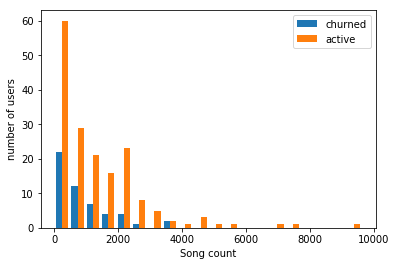

In [35]:
x=song_count_df[song_count_df.churn_phase==1]['count'].values
y=song_count_df[song_count_df.churn_phase==0]['count'].values
plt.hist([x, y], bins = 20, label=['churned', 'active'])
plt.legend(loc='upper right')
plt.xlabel('Song count')
plt.ylabel('number of users')
plt.show()

### Discussion 4: On average churn vs non-churn users have similar number of average song play

In [36]:
# Users will prefer to play songs from some artists. So there will be artists whose songs are played more than others
# Lets see what are top artist (lets say top 10) and analyse them
artist_count = df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(F.desc('Artistcount'))

In [37]:
artist_count_df = artist_count.toPandas()

In [38]:
artist_count_df[0:10]

,Artist,Artistcount
0,Kings Of Leon,1841
1,Coldplay,1813
2,Florence + The Machine,1236
3,Dwight Yoakam,1135
4,BjÃÂ¶rk,1133
5,The Black Keys,1125
6,Muse,1090
7,Justin Bieber,1044
8,Jack Johnson,1007
9,Eminem,953


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

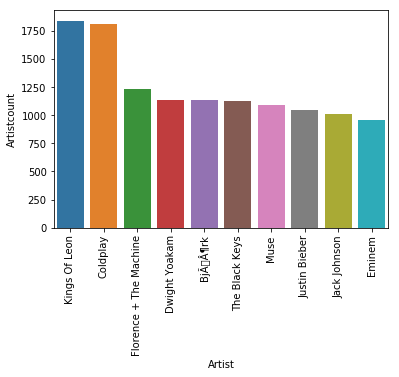

In [39]:
g = sns.barplot(x='Artist', y='Artistcount', data=artist_count_df[0:10] )
plt.xticks(rotation=90)

In [40]:
# We will try to convert timestamp to date format for day wise analysis
day = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1e3), DateType())
df = df.withColumn('date', day(F.col("ts")))

In [41]:
df.show(1)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+---------+-----------+-----------+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|downgrade|cancelled|churn_phase|song_played|      date|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+---------+-----------+-----------+----------+
|  null|Logged In| Darianna|     F|           34|Carpenter|  null| free|Bridgeport-Stamfo...|   PUT|Logout|1538016340000|      187|null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|    0|        0|        0|          0|          0|2018-11-21|
+------+----

In [42]:
# group by next song events when churn phase == 1 w.r.t. date and user id. 
df.filter((df.page=='NextSong')&(df.churn_phase == 1)) \
    .select('page', 'date', 'userId') \
    .groupby('date', 'userId') \
    .count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037882|71.24764235703726|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+



In [43]:
#Overall describe
df.filter((df.page=='NextSong')&(df.churn_phase == 1)) \
    .select('page', 'date') \
    .groupby('date') \
    .count().describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|                54|
|   mean| 673.9629629629629|
| stddev|510.35522083404277|
|    min|                26|
|    max|              2047|
+-------+------------------+



In [44]:
# group by next song events when churn phase == 0 w.r.t. date and user id. 
df.filter((df.page=='NextSong')&(df.churn_phase == 0)) \
    .select('page', 'date', 'userId') \
    .groupby('date', 'userId') \
    .count().describe().show()

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493971|74.02407951472071|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



In [45]:
df.filter((df.page=='NextSong')&(df.churn_phase == 0)) \
    .select('page', 'date') \
    .groupby('date') \
    .count().describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|                63|
|   mean|3043.0793650793653|
| stddev|1117.7043336547276|
|    min|                 1|
|    max|              5573|
+-------+------------------+



In [46]:
# filter out 0 sum and max sum to get more exact answer
#How many songs do users listen to on average between visiting our home page?
function = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts', 'churn_phase') \
    .withColumn('homevisit', function(F.col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+



In [47]:
# Lets see if there is a difference between churn and non-chrun users
cusum.filter((cusum.page=='NextSong') & (cusum.churn_phase == 1)) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
|  22.6612702366127|
+------------------+



In [48]:
# Lets see if there is a difference between churn and non-chrun users
cusum.filter((cusum.page=='NextSong') & (cusum.churn_phase == 0)) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.79175974187143|
+------------------+



### Discussion 5: It appears that on average customer who churned has lesser number of songs played between their visits (Two consecutive home page visits)

In [49]:
# Do people listening habbit differ in two groups, i.e. do people song legths differ
df.select(['length', 'churn_phase']).groupBy('churn_phase').agg({'length': 'mean'}).show()

+-----------+------------------+
|churn_phase|       avg(length)|
+-----------+------------------+
|          0|249.20913538880808|
|          1| 248.6327956440622|
+-----------+------------------+



### Discussion 6: From above table it is clear that people who churned have less mean length of song played when compared to non-churned users

In [50]:
# Lets check if there is any effect of error page on churn
df.filter((df.page=='Error')).groupBy('churn_phase').count().show()

+-----------+-----+
|churn_phase|count|
+-----------+-----+
|          0|  220|
|          1|   32|
+-----------+-----+



In [51]:
# Compute mean freinds added for each user
count_freinds = df.select('userId', 'page', 'churn_phase')\
                    .filter(df.page == 'Add Friend')\
                    .groupBy('userId', 'churn_phase') \
                    .agg({'page': 'count'}) \
                    .withColumnRenamed('count(page)', 'count_freinds')

In [52]:
count_freinds_df = count_freinds.toPandas()

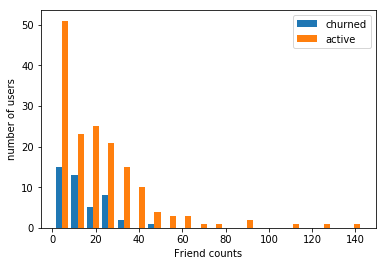

In [53]:
x=count_freinds_df[count_freinds_df.churn_phase==1]['count_freinds'].values
y=count_freinds_df[count_freinds_df.churn_phase==0]['count_freinds'].values
plt.hist([x, y], bins = 20, label=['churned', 'active'])
plt.legend(loc='upper right')
plt.xlabel('Friend counts')
plt.ylabel('number of users')
plt.show()

In [54]:
# I want to analyse if song skipping has some effect on user churn events.. So after removing thumps up/thumbs down
# events which may mostly appear duing song play, I am comparing length of song played between two consecutive next
# song page. If the song length played is differnt than song actual length then we can assume that songs were skipped.
session = Window.partitionBy("userId", "sessionId").orderBy(F.desc("ts"))

skipped = df.select("userId", "sessionId", "itemInSession", "page", "ts", "length")\
            .filter((df.page != "Thumbs Up") & (df.page != "Thumbs Down")) \
            .withColumn('next_song', F.when(df.page == "NextSong", 1).otherwise(0))\
            .orderBy('userId', 'sessionId', 'itemInSession') \
            .withColumn('next_lag_song', F.lag(F.col('next_song')).over(session))\
            .withColumn('ts_diff', (F.lag('ts').over(session)-F.col('ts'))/1000)\
            .withColumn('time_skipped', (F.floor('length')-F.col('ts_diff'))) \
            .filter(((F.col("time_skipped") >= 0) & (F.col("next_song") ==1)) & (F.col("next_lag_song") != 0)) \
            .withColumn('skipped', F.when(F.col("time_skipped") == 0, 0).otherwise(1)) \
            .groupby('userId')\
            .agg({'skipped': 'sum', 'time_skipped': 'mean'}) \
            .withColumnRenamed('sum(skipped)', 'total_songs_skipped')\
            .withColumnRenamed('avg(time_skipped)', 'avg_length_skipped')
            

In [55]:
skipped.orderBy(F.desc("total_songs_skipped")).show()

+------+------------------+-------------------+
|userId|avg_length_skipped|total_songs_skipped|
+------+------------------+-------------------+
|100010|               0.0|                  0|
|200002|               0.0|                  0|
|   125|               0.0|                  0|
|    51|               0.0|                  0|
|   124|               0.0|                  0|
|     7|               0.0|                  0|
|    54|               0.0|                  0|
|    15|               0.0|                  0|
|   155|               0.0|                  0|
|100014|               0.0|                  0|
|   132|               0.0|                  0|
|   154|               0.0|                  0|
|   101|               0.0|                  0|
|    11|               0.0|                  0|
|300017|               0.0|                  0|
|   138|               0.0|                  0|
|    29|               0.0|                  0|
|    69|               0.0|             

### Discussion 7: In my analysis, it appears that people are not skipping songs. But it is possible that we are working on small subset and the actual larger dataset may not display same property. So for larger dataset, I maay need to analyse it once more and then decide if I want to include this into modelling.



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [56]:
# Lets create feature engineering function
def feature_engineering(file_path):
    """
    This function creates necessary features for our machine learning model. 
    Input:
        file_path: A json file as input
    output:
        features: user specific feature dataframe for modelling
    """
    # Read json file
    df = spark.read.json(file_path)
    
    # Remove users who have empty user ID
    users = df.filter(df["userId"] != "")
    
    # Create custom udf functions
    churn = F.udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade = F.udf(lambda x: int(x == "Downgrade"), IntegerType())
    day = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1e3), DateType())
    home = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())
    next_song = F.udf(lambda isnext: int(isnext == ""))
    df = df.withColumn('song_played', F.when(df.page == "NextSong", 1).otherwise(0))
        
    # Partion data on time based window
    windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    session_window =  Window.partitionBy("userId", "sessionId").orderBy(F.desc("ts"))\
                            .rangeBetween(Window.unboundedPreceding, 0)

    # Create a date feature from time stamp column
    users = users.withColumn('date', day(F.col("ts")))
    
    # compute how many Add to Playlist is performed for each user on daily basis
    avg_add_playlist = users.select('userId', 'page', 'date')\
                            .filter(users.page == 'Add to Playlist')\
                            .groupBy('userId', 'date') \
                            .agg({'page': 'count'}) \
                            .groupby('userId') \
                            .mean()\
                            .withColumnRenamed('avg(count(page))', 'avg_playlist_add')
    
    # Compute avg error page faced by each user 
    avg_error = users.select('userId', 'page', 'date')\
                            .filter(users.page == 'Error')\
                            .groupBy('userId', 'date') \
                            .agg({'page': 'count'}) \
                            .groupby('userId') \
                            .mean()\
                            .withColumnRenamed('avg(count(page))', 'avg_error')
    
    # compute avg no of Help asked by each user
    avg_help = users.select('userId', 'page', 'date')\
                            .filter(users.page == 'Help')\
                            .groupBy('userId', 'date') \
                            .agg({'page': 'count'}) \
                            .groupby('userId') \
                            .mean()\
                            .withColumnRenamed('avg(count(page))', 'avg_help')
    
    # Compute how many thumbs up were done by a user on average
    avg_thumbs_up = users.select('userId', 'page', 'date')\
                            .filter(users.page == 'Thumbs Up')\
                            .groupBy('userId', 'date') \
                            .agg({'page': 'count'}) \
                            .groupby('userId') \
                            .mean()\
                            .withColumnRenamed('avg(count(page))', 'avg_thumbs_up')
    
    # Compute how many thumbs down were done by a user
    avg_thumbs_down = users.select('userId', 'page', 'date')\
                            .filter(users.page == 'Thumbs Down')\
                            .groupBy('userId', 'date') \
                            .agg({'page': 'count'}) \
                            .groupby('userId') \
                            .mean()\
                            .withColumnRenamed('avg(count(page))', 'avg_thumbs_down')
    
    # Compute mean freinds added for each user
    count_freinds = users.select('userId', 'page')\
                        .filter(users.page == 'Add Friend')\
                        .groupBy('userId') \
                        .agg({'page': 'count'}) \
                        .withColumnRenamed('count(page)', 'count_freinds')
    
    # Calculate Average number of songs played before user moved to home page
    cusum = users.filter((users.page == 'NextSong') | (users.page == 'Home')) \
                .select('userID', 'page', 'ts') \
                .withColumn('homevisit', home(F.col('page'))) \
                .withColumn('period', F.sum('homevisit').over(windowval))

    avg_num_song_till_home = cusum.filter((cusum.page == 'NextSong')) \
                                    .groupBy('userID', 'period') \
                                    .agg({'period':'count'}).drop('period') \
                                    .groupby('userID').mean() \
                                    .withColumnRenamed('avg(count(period))', 'avg_num_songs')
    
    # Create a feature for paid vs free user
    paid_free = users.select('userID', 'level') \
                        .dropDuplicates() \
                        .withColumn('paid_free', F.when(users.level == "paid", 1).otherwise(0)) \
                        .drop('level')
    
    gender = users.select('userId', 'gender')\
                    .dropDuplicates() \
                    .withColumn('gender_type', F.when(users.gender == "M", 1).otherwise(0)) \
                    .drop('gender')
    
    # whether a user has downgraded or not
    churn = users.withColumn("churn", F.when((users.page == "Cancellation Confirmation") , 1).otherwise(0)) \
                    .withColumn("vist_downgrade", F.when((users.page == "Downgrade") , 1).otherwise(0)) \
                    .withColumn("downgrade", F.when((users.page == "Submit Downgrade") , 1).otherwise(0)) \
                    .select(['userId', 'churn', 'vist_downgrade', "downgrade"]) \
                    .groupBy('userId') \
                    .sum()\
                    .withColumnRenamed('sum(churn)', 'churn') \
                    .withColumnRenamed('sum(vist_downgrade)', 'vist_downgrade') \
                    .withColumnRenamed('sum(downgrade)', 'downgrade')

    
    # Combine all the features computed above to create feature dataframe
    features = avg_thumbs_up.join(avg_thumbs_down, on='userID')
    features = features.join(avg_num_song_till_home, on='userID')
    features = features.join(avg_add_playlist, on='userID')
    features = features.join(avg_error, on='userID')
    features = features.join(avg_help, on='userID')
    features = features.join(count_freinds, on='userID')
    features = features.join(paid_free, on='userID')
    features = features.join(gender, on='userID')
    features = features.join(churn, on='userID')
    
    return features
    

In [57]:
# Define a function to get vector assembler and transform data 
def feature_prep(df):
    """
    Function to get vector assembler for modelling
    input:
        df: feature dataframe
    output:
        transfored data
    """
    feat_vec = VectorAssembler(inputCols=df.drop('userId', 'churn').columns, outputCol='features')
    transformed_data = feat_vec.transform(df)
    return transformed_data

In [58]:
def train_test(df):
    """
    Function to split data into training and testing (training and validation)
    Input:
        df: transformed data frame
    output:
        training data: dataframe for trainign
        remaining_data: remaining data frame for validation/test
    """
    (training_data, remaining_data) = df.randomSplit([0.8,0.2], seed = 21)
#     (test_data, val_data) = remaining_data.randomSplit([0.5,0.5], seed=21)
    return training_data, remaining_data, #test_data, val_data

In [59]:
feat = feature_engineering("mini_sparkify_event_data.json")

In [60]:
tran_feat = feature_prep(feat)
train, rest = train_test(tran_feat)

In [61]:
train.take(1)

[Row(userId='51', avg_thumbs_up=8.333333333333334, avg_thumbs_down=2.1, avg_num_songs=29.319444444444443, avg_playlist_add=5.2, avg_error=1.0, avg_help=1.7142857142857142, count_freinds=28, paid_free=1, gender_type=1, churn=1, vist_downgrade=23, downgrade=0, features=DenseVector([8.3333, 2.1, 29.3194, 5.2, 1.0, 1.7143, 28.0, 1.0, 1.0, 23.0, 0.0]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [62]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
import numpy as np

def evaluate_model(predictions, model):
    """
    This function evaluates model performance given prediction dataframe
    input:
        predictions: prediction dataframe from the model
        model: model name
    """
    preds_and_labels = predictions.select(['prediction', 'churn'])\
                                    .withColumn('label', F.col('churn').cast(FloatType()))
    
    #select only prediction and label columns
    # Ref: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
    preds_and_labels = preds_and_labels.select(['prediction','label'])
    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
    cm = metrics.confusionMatrix().toArray() 
    
    # Plot confusion matrix
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 12})
    ax.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')
    plt.show()
    
    # As accuracy is not a great metric for imbalanced dataset
    # Ref: https://stackoverflow.com/questions/41032256/get-same-value-for-precision-recall-and-f-score-in-apache-spark-logistic-regres
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[0][0])/(cm[0][0]+cm[1][0])
    recall=(cm[0][0])/(cm[0][0]+cm[0][1])
    f1Score = metrics.fMeasure()

    print(model)
    print("\t| accuracy = {}".format(accuracy))
    print("\t| precision = {}".format(precision))
    print("\t| recall = {}".format(recall))
    print("\t| f1-score = {}".format(f1Score))
    return f1Score

In [63]:
import pandas as pd
from itertools import chain
model_perf_df = pd.DataFrame([], columns=['model_name', 'f1_score'])

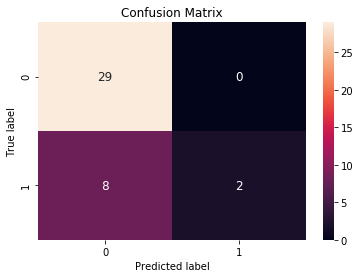

Logistic regression
	| accuracy = 0.7948717948717948
	| precision = 0.7837837837837838
	| recall = 1.0
	| f1-score = 0.7948717948717948


In [64]:
# train a logistic regression without parameter optimisation
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churn')
lr_base_model = lr.fit(train)
lr_predictions = lr_base_model.transform(rest)
lr_base_f1 = evaluate_model(lr_predictions, 'Logistic regression')

In [65]:
model_perf_df.loc[0] = ['logistic_base', lr_base_f1]

In [66]:
# Fit a logistic regression model using cross validation and grid search. Best model is used for evaluation
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churn', maxIter=10)
paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam,[0.1, 0.01]) \
            .addGrid(lr.fitIntercept, [True, False]) \
            .build()


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName="f1"),
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
print(cvModel_q1.avgMetrics)

[0.7350110134746894, 0.7164300301878238, 0.7292801272484472, 0.7220055623688606]


{Param(parent='LogisticRegression_974241514aa0', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_974241514aa0', name='fitIntercept', doc='whether to fit an intercept term.'): True}


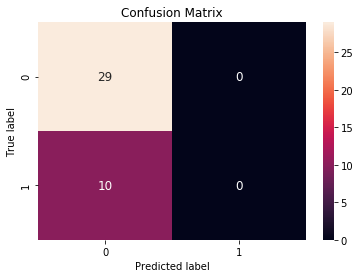

Logistic regression
	| accuracy = 0.7435897435897436
	| precision = 0.7435897435897436
	| recall = 1.0
	| f1-score = 0.7435897435897436


In [67]:
print(cvModel_q1.getEstimatorParamMaps()[ np.argmax(cvModel_q1.avgMetrics) ])
model = cvModel_q1.bestModel
lr_predictions = model.transform(rest)
lr_opt_f1 = evaluate_model(lr_predictions, 'Logistic regression')

In [68]:
model_perf_df.loc[1] = ['logistic_optimised', lr_opt_f1]

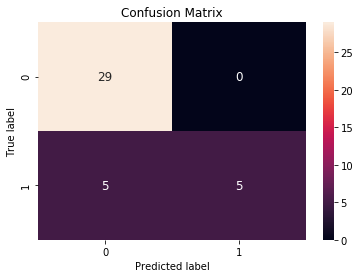

Random forest classification
	| accuracy = 0.8717948717948718
	| precision = 0.8529411764705882
	| recall = 1.0
	| f1-score = 0.8717948717948718


In [69]:
# Train base random forest model
rf = RandomForestClassifier(labelCol='churn', 
                            featuresCol='features')
rf_base_model = rf.fit(train)
rf_predictions = rf_base_model.transform(rest)
rf_base_f1 = evaluate_model(rf_predictions, 'Random forest classification')

In [70]:
model_perf_df.loc[2] = ['randomforest_base', rf_base_f1]

[0.8170020248648224, 0.7998605246113552, 0.8328842049677161, 0.8524124913484523]
{Param(parent='RandomForestClassifier_16454914f2b3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 7, Param(parent='RandomForestClassifier_16454914f2b3', name='numTrees', doc='Number of trees to train (>= 1).'): 40}


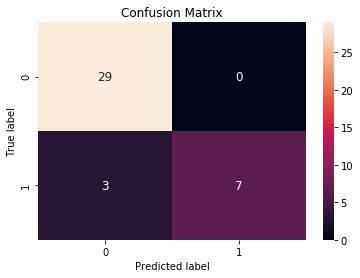

Random forest classification
	| accuracy = 0.9230769230769231
	| precision = 0.90625
	| recall = 1.0
	| f1-score = 0.9230769230769231


In [71]:
# Train a random forest model using cross validation and grid search. Best model is used for evaluation
rf = RandomForestClassifier(labelCol='churn', 
                            featuresCol='features')
paramGrid = ParamGridBuilder() \
            .addGrid(rf.maxDepth,[5, 7]) \
            .addGrid(rf.numTrees, [20, 40])\
            .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName="f1"),
                          numFolds=3)
cvModel_rf = crossval.fit(train)
print(cvModel_rf.avgMetrics)
print(cvModel_rf.getEstimatorParamMaps()[ np.argmax(cvModel_rf.avgMetrics) ])
model_rf = cvModel_rf.bestModel
rf_predictions = model_rf.transform(rest)
rf_opt_f1 = evaluate_model(rf_predictions, 'Random forest classification')

In [72]:
model_perf_df.loc[3] = ['randomforest_opt', rf_opt_f1]

In [73]:
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*train
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

In [74]:
rf_imp = [(name, model_rf.featureImportances[idx])
 for idx, name in attrs
 if model_rf.featureImportances[idx]]

In [75]:
imp = pd.DataFrame(rf_imp, columns=['feature', 'importance'])

[Text(0.5,1,'Feature importance for random forest')]

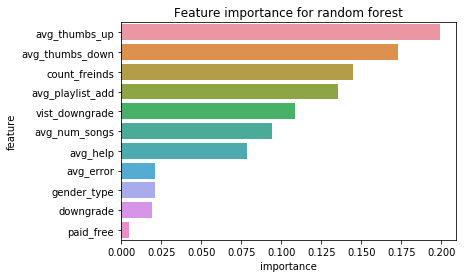

In [76]:
ax = sns.barplot(y="feature", x="importance", data=imp, order=imp.feature[imp.importance.argsort()[::-1]])

ax.set(title='Feature importance for random forest')

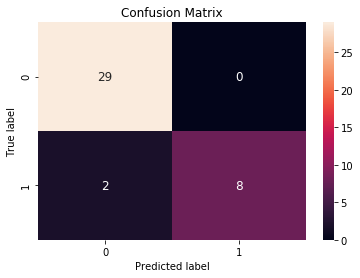

Gradient boosting classification
	| accuracy = 0.9487179487179487
	| precision = 0.9354838709677419
	| recall = 1.0
	| f1-score = 0.9487179487179487


In [77]:
# Train base gradient boosted model
gbt = GBTClassifier(labelCol = 'churn', featuresCol = 'features' ,)
gbt_base_model = gbt.fit(train)
gbt_predictions = gbt_base_model.transform(rest)
gbt_base_f1 = evaluate_model(gbt_predictions, 'Gradient boosting classification')

In [78]:
model_perf_df.loc[4] = ['Gradient_boosted_base', gbt_base_f1]

In [79]:
model_perf_df

,model_name,f1_score
0,logistic_base,0.794872
1,logistic_optimised,0.743590
2,randomforest_base,0.871795
3,randomforest_opt,0.923077
4,Gradient_boosted_base,0.948718


In [80]:
# Train a gradient boosted classifer using cross validation and grid search. Best model is used for evaluation
gbt = GBTClassifier(labelCol = 'churn', featuresCol = 'features' ,)
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth,[5, 4]) \
            .addGrid(gbt.maxIter, [10, 20])\
            .build()


crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName="f1"),
                          numFolds=3)
cvModel_gbt = crossval.fit(train)
print(cvModel_gbt.avgMetrics)
print(cvModel_gbt.getEstimatorParamMaps()[ np.argmax(cvModel_gbt.avgMetrics) ])
model = cvModel_gbt.bestModel

[0.7887524255960001, 0.7999635995882004, 0.786212609855879, 0.8199956312913124]
{Param(parent='GBTClassifier_794f50d3c9ba', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4, Param(parent='GBTClassifier_794f50d3c9ba', name='maxIter', doc='max number of iterations (>= 0).'): 20}


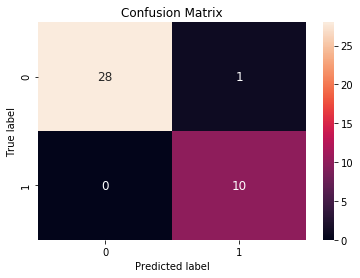

Gradient boosting classification
	| accuracy = 0.9743589743589743
	| precision = 1.0
	| recall = 0.9655172413793104
	| f1-score = 0.9743589743589743


In [81]:
gbt_predictions = model.transform(rest)
gbt_opt_f1 = evaluate_model(gbt_predictions, 'Gradient boosting classification')

In [82]:
model_perf_df.loc[5] = ['Gradient_boosted_opt', gbt_opt_f1]

[Text(0.5,1,'Feature importance for Gradient boosting classifier')]

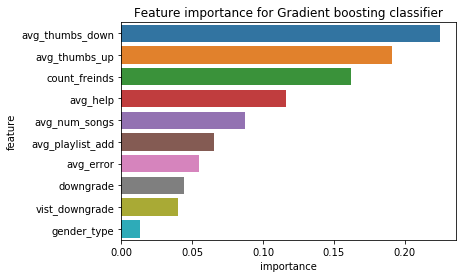

In [83]:
gbt_imp = [(name, model.featureImportances[idx])
 for idx, name in attrs
 if model.featureImportances[idx]]

imp = pd.DataFrame(gbt_imp, columns=['feature', 'importance'])
ax = sns.barplot(y="feature", x="importance", data=imp, order=imp.feature[imp.importance.argsort()[::-1]])
ax.set(title='Feature importance for Gradient boosting classifier')

In [89]:
# Model performance from all the data
model_perf_df.T

,0,1,2,3,4,5
model_name,logistic_base,logistic_optimised,randomforest_base,randomforest_opt,Gradient_boosted_base,Gradient_boosted_opt
f1_score,0.794872,0.74359,0.871795,0.923077,0.948718,0.974359


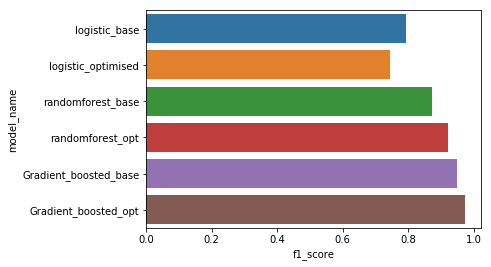

In [88]:
ax= sns.barplot(y='model_name', x='f1_score', data=model_perf_df)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.